In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from UCB_discrete import H_UCB, UCB1, UCB_V, MV_LCB, MARAB, Exp3
from collections import defaultdict
from Environment import Clinical_env
from SimulatedGames import simulate
from ipywidgets import IntProgress
from IPython.display import display
import plots
import seaborn as sns

%matplotlib inline

## Applications of HazardUCB 

For clinical experiments, for cancer patients (samples), there are several treatments (arms), the reward is how long can a patient survive after the treatment (rewards). The goal is to minimize the sub-optimal treatment. This is in the field of survival analysis, thus the hazard rate assumption and medians are good choice.

Data: Glinoma (cancer) clininal data from Broad Institute Firehouse https://gdac.broadinstitute.org/

In [2]:
#data = pd.read_csv('gdac.broadinstitute.org_GBMLGG.Clinical_Pick_Tier1.Level_4.2016012800.0.0/GBMLGG.clin.merged.picked.txt', delimiter= "\t", header = 0)
data = pd.read_csv('gdac.broadinstitute.org_STES.Clinical_Pick_Tier1.Level_4.2016012800.0.0/STES.clin.merged.picked.txt', delimiter= "\t", header = 0)
data = data.T
data.columns = data.iloc[0]
data = data.drop(data.index[0])
data.head()

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,radiation_therapy,karnofsky_performance_score,number_pack_years_smoked,race,ethnicity
tcga-ic-a6rf,value,69,0,NaN,477,stage ia,t1,n0,m0,female,no,NaN,22,white,not hispanic or latino
tcga-jy-a6fb,value,77,0,NaN,1837,stage i,t1,n0,m0,male,no,NaN,NaN,white,NaN
tcga-jy-a938,value,75,0,NaN,1060,stage iib,t3,n0,m0,male,no,NaN,NaN,white,NaN
tcga-l5-a43i,value,77,1,556,NaN,stage iiia,t3,n1,mx,male,yes,NaN,45,white,NaN
tcga-l5-a43j,value,90,1,131,NaN,stage iib,t3,n0,mx,male,NaN,NaN,54,white,NaN


### Explain columns

'days_to_death': rewards (lifetime distributions)  
'radiation_therapy': two arms (yea/no)
    
needs to drop NaN

In [3]:
days_to_death_with_radiation = data.groupby(['radiation_therapy']).get_group('yes')['days_to_death']
days_to_death_without_radiation = data.groupby(['radiation_therapy']).get_group('no')['days_to_death']

days_to_death_with_radiation = np.asarray(days_to_death_with_radiation.dropna(), dtype = int)
days_to_death_without_radiation = np.asarray(days_to_death_without_radiation.dropna(), dtype = int)

The number of samples with radiation:  33
Median:  436.0  Mean:  605.3333333333334

The number of samples without radiation:  194
Medians:  343.0  Mean:  424.8917525773196


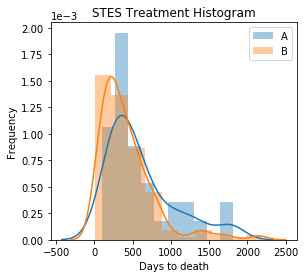

In [4]:
# Show reward distribution info
#from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(5 * 3 , 4))
plt.subplot(1,3, 1)
print('The number of samples with radiation: ', len(days_to_death_with_radiation))
print('Median: ', np.median(days_to_death_with_radiation), ' Mean: ', np.mean(days_to_death_with_radiation))
print()
print('The number of samples without radiation: ', len(days_to_death_without_radiation))
print('Medians: ', np.median(days_to_death_without_radiation), ' Mean: ', np.mean(days_to_death_without_radiation))

sns.distplot(days_to_death_with_radiation, bins = 10, label = 'A', norm_hist=True)
sns.distplot(days_to_death_without_radiation, bins = 10, label = 'B', norm_hist=True)
plt.xlabel('Days to death')
plt.ylabel('Frequency')
#axs.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('STES Treatment Histogram')
plt.legend()
#plt.savefig('STES_hist.pdf', bbox_inches='tight')

In [5]:
def cal_mvs(data, rho):
    return np.var(data) - rho * np.mean(data)

### Setup Environment

In [6]:
# setting

num_rounds = 1000
num_exper = 500
num_arms = 2

# environment

clinical_envs = defaultdict(list)
medians = defaultdict(list)
means = defaultdict(list)
mvs_small_rho = defaultdict(list)
mvs_big_rho = defaultdict(list)

paras = [50, 1e8] # [rho for MV, alpha for CVaR]

clinical_envs['STES'] = [Clinical_env(days_to_death_with_radiation),
                              Clinical_env(days_to_death_without_radiation)
                             ]

medians['STES'] = [np.median(days_to_death_with_radiation),
                        np.median(days_to_death_without_radiation)
                       ]

means['STES'] = [np.mean(days_to_death_with_radiation),
                        np.mean(days_to_death_without_radiation)
                       ]

mvs_small_rho['STES'] = [cal_mvs(days_to_death_with_radiation, paras[0]),
                       cal_mvs(days_to_death_without_radiation, paras[0])]

mvs_big_rho['STES'] = [cal_mvs(days_to_death_with_radiation, paras[1]),
                       cal_mvs(days_to_death_without_radiation, paras[1])]

evaluation = ['sd', 'r']



In [7]:
def run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, policy, medians, est_flag, evaluation):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            for est_flag in est_flags:
                name = key + '_' + str(num_exper) + '_' + str(num_rounds)
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                #if policy_name == 'Hazard_UCB_':  
                #    subname = policy_name + str(est_flag)[0] + '_' + str(hyperpara)
                subname = policy_name + str(hyperpara)
                print(name + subname)
                p = IntProgress(max = num_exper)
                p.description = 'Running'
                display(p)
                results[name][subname], results[name]['bound']= simulate(rewards_env[key], medians[key], policy, num_exper, num_rounds, est_flag, hyperpara, evaluation, p)

In [8]:
results = defaultdict(dict)

est_flags = [False]

# Hazard UCB

hyperpara_list = [[4, 2, 200]]


run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, H_UCB, medians, est_flags, evaluation)

#--------------------------------------------------------------------------------------------------------


# UCB1

hyperpara_list = [[100]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, UCB1, means, est_flags, evaluation)


# UCB_V

hyperpara_list = [[1.2, 1, 100]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, UCB_V, means, est_flags, evaluation)

# MV_LCB with small rho

hyperpara_list = [[paras[0], 100]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, MV_LCB, mvs_small_rho, est_flags, evaluation)

# Exp3

hyperpara_list = [[0.3, 0, 2000]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, Exp3, medians, est_flags, evaluation)

# MV_LCB with big rho

hyperpara_list = [[paras[1], 100]]
run_exper(clinical_envs, hyperpara_list, num_exper, num_rounds, MV_LCB, mvs_big_rho, est_flags, evaluation)



'''
# MARAB

hyperpara_list = [[paras[1], 0.1], [paras[1], 0.01], [paras[1], 1], [paras[1], 10]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, MARAB, cvars, est_flags, evaluation)
'''

STES_500_1000H_UCB-[4, 2, 200]


IntProgress(value=0, description='Running', max=500)

STES_500_1000UCB1-[100]


IntProgress(value=0, description='Running', max=500)

STES_500_1000UCB_V-[1.2, 1, 100]


IntProgress(value=0, description='Running', max=500)

STES_500_1000MV_LCB-[50, 100]


IntProgress(value=0, description='Running', max=500)

STES_500_1000Exp3-[0.3, 0, 2000]


IntProgress(value=0, description='Running', max=500)

STES_500_1000MV_LCB-[100000000.0, 100]


IntProgress(value=0, description='Running', max=500)

'\n# MARAB\n\nhyperpara_list = [[paras[1], 0.1], [paras[1], 0.01], [paras[1], 1], [paras[1], 10]]\nrun_exper(rewards_env, hyperpara_list, num_exper, num_rounds, MARAB, cvars, est_flags, evaluation)\n'

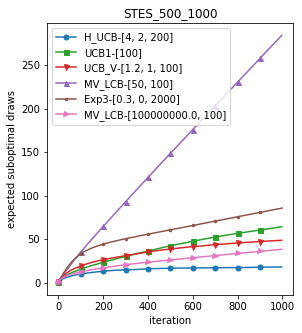

In [9]:
plots.plot_eva(results, 'sd', 'raw')

1


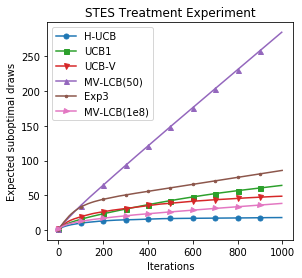

In [12]:
plots.plot_eva_for_clinical(results, 'sd')

The plots shows our policy performs good in terms of this application.

Note: 

the lower bound of hazard rate estimation (L) in this experiment is not calculated by L = h(0) = f(0)/(1 - F(0)) since we don't know the experssion of distributions. To estimate it, we use #(X <= 100)/# all samples.

In [11]:
import pickle 
saving = results

with open('os_saving_16.pickle', 'wb') as handle:
    pickle.dump(saving, handle, protocol=pickle.HIGHEST_PROTOCOL)